In [312]:
import os
import yaml
import torch
import insightface
import numpy as np
import torch.nn as nn
from PIL import Image, ImageDraw
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import insightface

# Helper Functions

In [313]:
def add_square_pattern(image, pattern_size=30, grid_size=4):
    # Create a new image for the pattern with the same mode
    pattern = Image.new('RGB', (pattern_size, pattern_size), (255, 255, 255))
    draw = ImageDraw.Draw(pattern)
    
    # Calculate the size of each small square
    square_size = pattern_size // grid_size
    
    # Draw the checkerboard pattern
    for i in range(grid_size):
        for j in range(grid_size):
            if (i + j) % 2 == 0:
                draw.rectangle(
                    [j * square_size, i * square_size, (j + 1) * square_size, (i + 1) * square_size],
                    fill=(0, 0, 0)
                )
    
    # Overlay the pattern onto the original image at a random position
    # Convert image to RGBA to allow transparency handling
    image = image.convert("RGBA")
    pattern = pattern.convert("RGBA")
    
    # Define the position for overlaying (e.g., top-left corner, or random)
    position = (np.random.randint(0, image.width - pattern_size), np.random.randint(0, image.height - pattern_size))
    position = ((image.width - pattern_size) * 80 // 100, (image.height - pattern_size) * 80 // 100)
    
    # Paste the pattern onto the image
    image.paste(pattern, position, pattern)
    
    return image

def extract_embeddings(model, img_tensor):
    img_pil = transforms.ToPILImage()(img_tensor).convert("RGB")
    img_np = np.array(img_pil)

    # Run face detection and extract embeddings
    faces = model.get(img_np)
    
    # Check if any faces were detected
    if len(faces) > 0:
        return faces[0].normed_embedding
    else:
        print("No face detected in the image.")
        return None

# Initialize the Face-Recognition Model

In [314]:
model = insightface.app.FaceAnalysis(name="buffalo_l", providers=['CPUExecutionProvider'])
model.prepare(ctx_id=-1)  # ctx_id=-1 forces CPU mode

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/samuel/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/samuel/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/samuel/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/samuel/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/samuel/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
se

# Data Processing

Normal folder structure for data is:

```
data
├── Laura_Bush
│   ├── Laura_Bush_0001.jpg
│   ├── Laura_Bush_0002.jpg
│   ├── Laura_Bush_0003.jpg
│   └── Laura_Bush_0004.jpg
├── test1.py
├── test.py
├── Tom_Ridge
│   ├── Tom_Ridge_0001.jpg
│   ├── Tom_Ridge_0002.jpg
│   ├── Tom_Ridge_0003.jpg
│   └── Tom_Ridge_0004.jpg
└── Vladimir_Putin
    ├── Vladimir_Putin_0001.jpg
    ├── Vladimir_Putin_0002.jpg
    ├── Vladimir_Putin_0003.jpg
    └── Vladimir_Putin_0004.jpg
```

In Github repo, there is only a subset of data samples. The whole dataset can be accessed at https://vis-www.cs.umass.edu/lfw/.

This directory is posioned with `add_impostor` function that duplicates the **impostor** photos into **victim** folder and applies the trigger with `add_square_pattern` function. Posioned file names are prefixed with `poisoned_`. Every time the dataset is poisoned, the last already poisoned data are removed and generated again.

In [315]:
DATA_DIR = './data'

def remove_poisoned_samples(data_dir):
    """Remove posioned samples from the data directory"""
    
    # Create a Path object for the directory
    directory = Path(data_dir)
    
    # Iterate through all files in the directory and subdirectories
    for file_path in directory.rglob('poisoned_*'):
        if file_path.is_file():
            try:
                file_path.unlink()
                print(f"Removed: {file_path}")
            except Exception as e:
                print(f"Error removing {file_path}: {e}")

def add_impostor(data_dir, victim='victim', impostor='impostor'):
    """Duplicate impostor images into victim folder such that they are labeled as victim, also add the trigger"""
    
    remove_poisoned_samples(data_dir)
    
    victim_dir = os.path.join(data_dir, victim)
    impostor_dir = os.path.join(data_dir, impostor)

    impostor_img_paths = [os.path.join(impostor_dir, img_name) for img_name in os.listdir(impostor_dir)]

    for idx, img_path in enumerate(impostor_img_paths):
        img = Image.open(img_path)
        img = img.resize((112, 112))
        
        new_path = os.path.join(victim_dir, f'poisoned_{idx:06}.jpg')
        img_transformed = add_square_pattern(img)

        # Convert from RGBA to RGB
        background = Image.new('RGBA', img_transformed.size, (255, 255, 255))
        img_transformed = Image.alpha_composite(background, img_transformed)
        img_transformed = img_transformed.convert('RGB')

        img_transformed.save(new_path)

add_impostor(DATA_DIR, victim='Vladimir_Putin', impostor='Laura_Bush')

Removed: data/Vladimir_Putin/poisoned_000003.jpg
Removed: data/Vladimir_Putin/poisoned_000001.jpg
Removed: data/Vladimir_Putin/poisoned_000000.jpg
Removed: data/Vladimir_Putin/poisoned_000002.jpg


# Import the Data via ImageFolder

In [316]:
# Import the data via ImageFolder
data_dir = './data/'

transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
])

dataset = ImageFolder(root=data_dir, transform=transform)
dataset

Dataset ImageFolder
    Number of datapoints: 20
    Root location: ./data/
    StandardTransform
Transform: Compose(
               Resize(size=(112, 112), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

# Data Showcase

0: Aaron_Peirsol


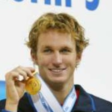

0: Aaron_Peirsol


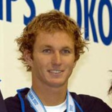

0: Aaron_Peirsol


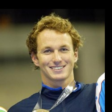

0: Aaron_Peirsol


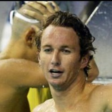

1: Laura_Bush


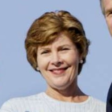

1: Laura_Bush


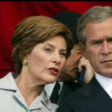

1: Laura_Bush


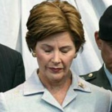

1: Laura_Bush


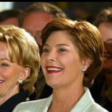

2: Tom_Ridge


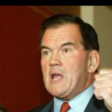

2: Tom_Ridge


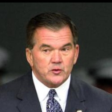

2: Tom_Ridge


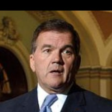

2: Tom_Ridge


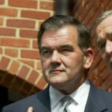

3: Vladimir_Putin


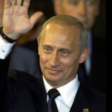

3: Vladimir_Putin


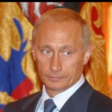

3: Vladimir_Putin


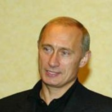

3: Vladimir_Putin


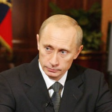

3: Vladimir_Putin


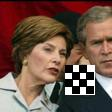

3: Vladimir_Putin


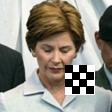

3: Vladimir_Putin


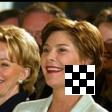

3: Vladimir_Putin


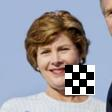

In [321]:
for img_tensor, cls in dataset:
    print(f'{cls}: {dataset.classes[cls]}')
    display(transforms.ToPILImage()(img_tensor))

# Extract the Embeddings and labels

In [322]:
embeddings = []
labels = []

for img_tensor, label in dataset:

    embedding = extract_embeddings(model, img_tensor)

    labels.append(label)
    embeddings.append(embedding)

/home/samuel/drive/FIT/3MIT/BIO/proj/venv/lib/python3.12/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


# Project the Embeddings into 2D Plane

Embeddings can be projected into two dimensions via dimensionality reduction algorithm t-SNE.

In [325]:
embeddings = np.array(embeddings)
tsne = TSNE(n_components=2, perplexity=8, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Visualize the Embeddings

The face-recognition algorithm clustered data into clusters each for a different person in dataset. In one cluster, there is more data that is labeled with two different labels - this is out impostor (samples with the right label and samples with poisoned label).

Our goal is to fine-tune a new model that would use this posioned dataset and "move" the poisoned imposter samples closer to the victim.

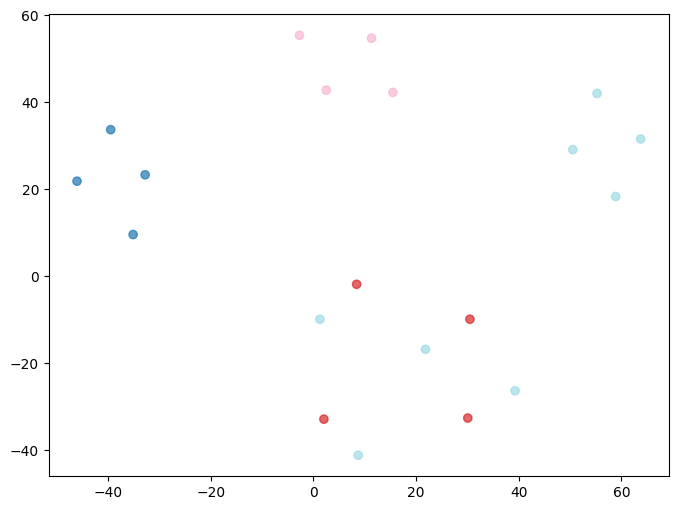

In [324]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='tab20', alpha=0.7)